In [191]:
from __future__ import annotations

import itertools
import math
from pathlib import Path
import re
from typing import Any, Iterable, Optional, Union
import warnings
import sys

import geopandas
import matplotlib
import matplotlib.axes
import matplotlib.cm
import matplotlib.figure
import matplotlib.pyplot
import mpl_toolkits.mplot3d
import numpy
import pandas
import plotly.graph_objs
# import seaborn
from shapely import Point
from sklearn.linear_model import LinearRegression
from scipy.optimize import Bounds
import scipy.stats

sys.path.append('../Packages/tectoniq')
from tectoniq.datasets import Mercedes
from tectoniq.functions import IFunction, Polynomial, Power, PowerWithOffset
from tectoniq.geometry import distance, distance_to_line, distance_to_line_segment
from tectoniq.optimization import fit_function
from tectoniq.normalization import *
import numpy as np
import pandas as pd
from sklearn import metrics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
def calculate_weights(differences, penalty_factor=1):
    # Higher penalty factor will penalize lower differences more
    return penalty_factor / (differences + penalty_factor)

def weighted_f1_score(data_frame, TARGET_COLUMN , target_threshold, ore_diff_threshold, penalty_factor=1):
    data_frame["Actual"] = data_frame[TARGET_COLUMN] >= target_threshold
    data_frame["Predicted"] = data_frame[ORE_DIFFERENCE_COLUMN] <= ore_diff_threshold
    
    data_frame["Weight"] = calculate_weights(data_frame[ORE_DIFFERENCE_COLUMN], penalty_factor)
    
    tp = data_frame[data_frame["Actual"] & data_frame["Predicted"]]
    fp = data_frame[~data_frame["Actual"] & data_frame["Predicted"]]
    fn = data_frame[data_frame["Actual"] & ~data_frame["Predicted"]]
    tn = data_frame[~data_frame["Actual"] & ~data_frame["Predicted"]]
    
    weighted_tp = tp["Weight"].sum()
    weighted_fp = fp["Weight"].sum()
    weighted_fn = fn["Weight"].sum()
    weighted_tn = tn["Weight"].sum()
    
    weighted_accuracy = (weighted_tp + weighted_tn) / (weighted_tp + weighted_tn + weighted_fp + weighted_fn)
    weighted_precision = weighted_tp / (weighted_tp + weighted_fp)
    weighted_recall = weighted_tp / (weighted_tp + weighted_fn)
    
    if weighted_precision + weighted_recall == 0:
        return 0
    
    weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)
    
    return round(weighted_f1, 4), round(weighted_precision, 4), round(weighted_recall, 4), round(weighted_accuracy, 4), tp, fp, fn, tn

def penalty_function(ore_difference, max_penalty=10):
    return max_penalty / (ore_difference + 0.1)  

def custom_loss(data_frame, TARGET_COLUMN , target_threshold, ore_diff_threshold, max_penalty=10):
    data_frame["Actual"] = data_frame[TARGET_COLUMN] >= target_threshold
    data_frame["Predicted"] = data_frame[ORE_DIFFERENCE_COLUMN] <= ore_diff_threshold
    
    false_positives = data_frame[~data_frame["Actual"] & data_frame["Predicted"]]
    false_negatives = data_frame[data_frame["Actual"] & ~data_frame["Predicted"]]
    
    fp_penalties = false_positives[ORE_DIFFERENCE_COLUMN].apply(penalty_function, max_penalty=max_penalty)
    fn_penalties = false_negatives[ORE_DIFFERENCE_COLUMN].apply(penalty_function, max_penalty=max_penalty)
    
    total_loss = fp_penalties.sum() + fn_penalties.sum()
    
    return total_loss

def normalize_ratio_columns(data_frame):
    temp_df = data_frame.copy()
    temp_df['(2Ca+Na+K)/Al'] = min_max_scaling(temp_df['(2Ca+Na+K)/Al'])
    temp_df['K/Al'] = log_then_min_max(temp_df['K/Al'])
    temp_df['As/Al'] = log_then_min_max(temp_df['As/Al'])
    temp_df['K/(Al-Na)'] = winsor_then_min_max(temp_df['K/(Al-Na)'])
    temp_df['CCPI'] = min_max_scaling(temp_df['CCPI'])
    temp_df['Ishikawa'] = min_max_scaling(temp_df['Ishikawa'])
    temp_df['Na/Al'] = min_max_scaling(temp_df['Na/Al'])
    temp_df['As (ppm)']  = robust_scaling(temp_df['As (ppm)'])
    
    return temp_df

## CONFIGURATION

In [194]:
AREA_ID_COLUMN = Mercedes.AREA_ID_COLUMN
DOMAIN_ID_COLUMN = Mercedes.DOMAIN_ID_COLUMN
DOMAIN_NAME_COLUMN = Mercedes.DOMAIN_NAME_COLUMN
GEOMETRY_COLUMN = Mercedes.GEOMETRY_COLUMN
ID_COLUMN = Mercedes.ID_COLUMN
RADIUS: float = 20
SAMPLE_COUNT_THRESHOLD: int = 20
TARGET_COLUMN: str = "Au (ppm)"
THRESHOLD: float = 3

COPPER_COLUMN: str = "Cu (ppm)"
GOLD_COLUMN: str = "Au (ppm)"

COLUMN_FIT_OPTIONS: dict[str, dict[str, Any]] = {
    "(2Ca+Na+K)/Al": {},
    "K/Al": {},
    "As/Al": {},
    "K/(Al-Na)": {},
    "CCPI": {},
    "Ishikawa": {},
    "Na/Al": {},
    "Fe (%)": {},
    "Ca (%)": {},
    "Na (%)": {},
    "K (%)": {},
    "Al (%)": {},
    "As (ppm)": {},
    "Cu (ppm)": {},
    "Mg (%)": {}
}
COLUMN_LIMITS: dict[str, tuple[float, float]] = {
    "(2Ca+Na+K)/Al": (0, 2.5),
    "K/Al": (0, 1.5),
    "As/Al": (0, 2000),
    "K/(Al-Na)": (-0.25, 1.5),
    "CCPI": (0, 1),
    "Ishikawa": (0, 100),
    "Na/Al": (0, 1.5),
    "Fe (%)": (0, 10),
    "Ca (%)": (0, 30),
    "Na (%)": (0, 10),
    "K (%)": (0, 10),
    "Al (%)": (0, 10),
    "As (ppm)": (0, 600),
    "Cu (ppm)": (0, 300),
    "Mg (%)": (0, 5),
}

PLOT_TYPE_DENSITY: str = "density"

RATIO_COLUMNS: list[str] = ["(2Ca+Na+K)/Al", "K/Al", "As/Al", "K/(Al-Na)", "CCPI", "Ishikawa", "Na/Al"]
RATIO_CONSTITUTENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "As (ppm)", "Cu (ppm)", "Mg (%)"]
KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Cu (ppm)", "Mg (%)"]
NORMALIZED_VECTOR_COLUMN: str = "NormalizedVector"
ORE_DIFFERENCE_COLUMN: str = "OreDifference"

# KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Mg (%)"]
# KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Cu (ppm)", "Mg (%)", "Ishikawa", "CCPI"]

DOMAIN_1_SUBSET_LINE: tuple[Point, Point] = Point(549250, 3356800), Point(550000, 3355500)
NULL_DOMAIN_BOTTOM_LEFT = Point(551200, 3355600)
NULL_DOMAIN_TOP_RIGHT = Point(551500, 3355850)

AREA_1_RHYOLITE_SAMPLE_NUMBER = "MRS-016"
AREA_1_ANDESITE_SAMPLE_NUMBER = "MRS-032"
AREA_1_ORE_SAMPLE_NUMBER = "MRS-001"
AREA_2_LIMESTONE_SAMPLE_NUMBER = "MRS-023"
AREA_2_SILTSTONE_SAMPLE_NUMBER = "M023228"
AREA_2_BG_SAMPLE_NUMBER = 695588

KEY_SAMPLE_NUMBERS = [AREA_1_RHYOLITE_SAMPLE_NUMBER, AREA_1_ANDESITE_SAMPLE_NUMBER, AREA_1_ORE_SAMPLE_NUMBER, AREA_2_LIMESTONE_SAMPLE_NUMBER, AREA_2_SILTSTONE_SAMPLE_NUMBER, AREA_2_BG_SAMPLE_NUMBER]

matplotlib.interactive(True)
warnings.filterwarnings("ignore")

In [195]:
def get_units(column: str) -> Optional[str]:
    unit_match: re.Match = re.search(r"\((.+)\)", column)
    return unit|_match.group() if unit_match else None

def print_df_summary(data_frame):
    total_rows = data_frame.shape[0]
    nan_count = data_frame[RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS].isna().sum()
    nan_percentage = (nan_count / total_rows) * 100
    nan_summary = pd.DataFrame({
        'NaN Count': nan_count,
        'NaN Percentage': nan_percentage
    })

    display(nan_summary.round(3))


In [196]:
data_frame: geopandas.GeoDataFrame = Mercedes.latest(Path("../Data"))
area_1_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[AREA_ID_COLUMN] == 1]
area_2_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[AREA_ID_COLUMN] == 2]
key_samples_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[ID_COLUMN].isin(KEY_SAMPLE_NUMBERS)]

display(key_samples_data_frame)

print(f"Initial Data Shape: {area_1_data_frame.shape}")
print(f"Initial Data Shape: {area_2_data_frame.shape}")

area_1_data_frame = area_1_data_frame[~((area_1_data_frame['Fe (%)'] == 0) | (area_1_data_frame['Fe (%)'].isna())) & ~(area_1_data_frame['Ca (%)'] == 0)]
area_1_data_frame = area_1_data_frame[~(area_1_data_frame['Na (%)'].isna())].reset_index(drop=True)

area_2_data_frame = area_2_data_frame[~((area_2_data_frame['Fe (%)'] == 0) | (area_2_data_frame['Fe (%)'].isna())) & ~(area_2_data_frame['Ca (%)'] == 0)]
area_2_data_frame = area_2_data_frame[~(area_2_data_frame['Na (%)'].isna())].reset_index(drop=True)

print(f"Initial Data Shape: {area_1_data_frame.shape}")
print(f"Initial Data Shape: {area_2_data_frame.shape}")

,SampleNumber,Easting,Northing,Latitude,Longitude,Elevation,Area,Type,Sampler,Au (ppm),...,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al,Geometry,DomainId,DomainName,AreaId
491,695588,555252.0000,3375385.000,30.509498,-110.424170,1407.0,La Mesa Ranch,Soil,EBD,0.005,...,0.345523,2.673392,0.391429,0.729098,64.153171,0.117276,POINT (555252.000 3375385.000),4.0,La Mesa,2.0
5832,M023228,553345.0000,3374929.000,30.505470,-110.444068,NaN,Arg.5_Molino,Sediment,MR,0.002,...,0.077626,28.310502,0.078341,0.610233,39.649794,0.009132,POINT (553345.000 3374929.000),4.0,La Mesa,2.0
6655,MRS-001,549179.9291,3355322.635,NaN,NaN,NaN,Mercedes,Rock Chip,Tectoniq,16.550,...,0.437500,56.250000,0.456522,0.949829,84.246132,0.041667,POINT (549179.929 3355322.635),1.0,Mercedes,1.0
6669,MRS-016,534011.2702,3355518.055,NaN,NaN,NaN,Bajio N,Rock Chip,Tectoniq,0.007,...,0.237047,NaN,0.375000,0.548017,43.966812,0.367876,POINT (534011.270 3355518.055),NaN,None,NaN
6676,MRS-023,553747.1017,3375146.065,NaN,NaN,1371.0,La Mesa,Rock Chip,Tectoniq,0.008,...,0.233645,11.682243,0.342466,0.042763,3.142721,0.317757,POINT (553747.102 3375146.065),4.0,La Mesa,2.0
6685,MRS-032,547580.8749,3352148.571,NaN,NaN,1018.0,La Leone,Rock Chip,Tectoniq,0.009,...,0.279123,1.268743,0.420139,0.465237,34.248710,0.335640,POINT (547580.875 3352148.571),NaN,None,NaN


Initial Data Shape: (3443, 72)
Initial Data Shape: (1723, 72)
Initial Data Shape: (3401, 72)
Initial Data Shape: (1723, 72)


## Analyzing

In [197]:
area_1_data_frame[RATIO_CONSTITUTENT_COLUMNS+RATIO_COLUMNS].describe().round().T[['mean']].T

,Fe (%),Ca (%),Na (%),K (%),Al (%),As (ppm),Cu (ppm),Mg (%),(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al
mean,2.0,1.0,1.0,4.0,5.0,180.0,56.0,1.0,15.0,3.0,107.0,0.0,1.0,76.0,2.0


In [198]:
area_1_data_frame = normalize_ratio_columns(area_1_data_frame)
area_1_data_frame = normalize_ratio_columns(area_2_data_frame)

In [199]:
display(area_1_data_frame[RATIO_CONSTITUTENT_COLUMNS+RATIO_COLUMNS].describe().round().T[['mean']].T)
print("45 PPM")
display(area_1_data_frame[area_1_data_frame[COPPER_COLUMN] >= 45][RATIO_CONSTITUTENT_COLUMNS+[GOLD_COLUMN]+RATIO_COLUMNS].describe().round(3).T[['mean']].T)
print("100 PPM")
display(area_1_data_frame[area_1_data_frame[COPPER_COLUMN] >= 100][RATIO_CONSTITUTENT_COLUMNS+[GOLD_COLUMN]+RATIO_COLUMNS].describe().round(3).T[['mean']].T)
print("10 PPM")
display(area_1_data_frame[area_1_data_frame[COPPER_COLUMN] <= 10][RATIO_CONSTITUTENT_COLUMNS+[GOLD_COLUMN]+RATIO_COLUMNS].describe().round(3).T[['mean']].T)

print("1 PPM")
display(area_1_data_frame[area_1_data_frame[COPPER_COLUMN] <= 1][RATIO_CONSTITUTENT_COLUMNS+[GOLD_COLUMN]+RATIO_COLUMNS].describe().round(3).T[['mean']].T)

,Fe (%),Ca (%),Na (%),K (%),Al (%),As (ppm),Cu (ppm),Mg (%),(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al
mean,3.0,5.0,1.0,2.0,6.0,1.0,28.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


45 PPM


,Fe (%),Ca (%),Na (%),K (%),Al (%),As (ppm),Cu (ppm),Mg (%),Au (ppm),(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al
mean,4.09,3.342,0.967,1.991,7.163,1.204,76.228,1.072,0.019,0.004,0.713,0.381,0.511,0.614,0.511,0.165


100 PPM


,Fe (%),Ca (%),Na (%),K (%),Al (%),As (ppm),Cu (ppm),Mg (%),Au (ppm),(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al
mean,3.153,6.081,0.956,1.161,4.462,1.016,233.286,1.141,0.051,0.02,0.69,0.496,0.52,0.473,0.337,0.237


10 PPM


,Fe (%),Ca (%),Na (%),K (%),Al (%),As (ppm),Cu (ppm),Mg (%),Au (ppm),(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al
mean,1.768,10.178,0.56,0.66,2.227,0.504,5.543,0.55,0.064,0.046,0.705,0.438,0.569,0.457,0.378,0.232


1 PPM


,Fe (%),Ca (%),Na (%),K (%),Al (%),As (ppm),Cu (ppm),Mg (%),Au (ppm),(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al
mean,1.695,32.5,0.095,0.135,0.54,0.344,1.0,1.005,0.004,0.226,0.708,0.622,0.456,0.064,0.036,0.174


In [85]:
# KEY ELEMENTS FOR COPPER
["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Mg (%)", "As (ppm)", "(2Ca+Na+K)/Al", "K/Al", "As/Al", "Ishikawa", "Na/Al"]

# COLS WITH NO DIFFERENCE
["CCPI"]

['CCPI']

## Grid Search

In [211]:
KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Mg (%)", "CCPI", "Ishikawa", "K/(Al-Na)", "As (ppm)"]
display(area_1_data_frame[area_1_data_frame[COPPER_COLUMN] >= 45][KEY_ELEMENT_COLUMNS].describe().round(3).T[['mean']].T)
display(area_1_data_frame[area_1_data_frame[COPPER_COLUMN] >= 100][KEY_ELEMENT_COLUMNS].describe().round(3).T[['mean']].T)
display(area_1_data_frame[area_1_data_frame[COPPER_COLUMN] <= 10][KEY_ELEMENT_COLUMNS].describe().round(3).T[['mean']].T)

,Fe (%),Ca (%),Na (%),K (%),Al (%),Mg (%),CCPI,Ishikawa,K/(Al-Na),As (ppm)
mean,4.09,3.342,0.967,1.991,7.163,1.072,0.614,0.511,0.511,1.204


,Fe (%),Ca (%),Na (%),K (%),Al (%),Mg (%),CCPI,Ishikawa,K/(Al-Na),As (ppm)
mean,3.153,6.081,0.956,1.161,4.462,1.141,0.473,0.337,0.52,1.016


,Fe (%),Ca (%),Na (%),K (%),Al (%),Mg (%),CCPI,Ishikawa,K/(Al-Na),As (ppm)
mean,1.768,10.178,0.56,0.66,2.227,0.55,0.457,0.378,0.569,0.504


In [212]:


AREA_1_ORE_VECTOR: numpy.array = numpy.array([4, 4, 1, 2, 6, 1, 0.6, 0.5, 0.5, 1])
NORMALIZATION_VECTOR: numpy.array = numpy.array([1.5, 10, 0.5, 0.5, 2, 0.5, 0.4, 0.3, 0.5, 0.5])


# Define the base vector
base_vector = NORMALIZATION_VECTOR

# Define the variations
variations = [
    base_vector,
    base_vector - np.array([1, 1, 0.05, 0.05, 1, 0.05, 0.04, 0.03, 0.05, 0.05]),
    base_vector + np.array([1, 1, 0.05, 0.05, 1, 0.05, 0.04, 0.03, 0.05, 0.05]),
    base_vector - np.array([2, 2, 0.1, 0.1, 2, 0.1, 0.08, 0.06, 0.1, 0.1]),
    base_vector + np.array([2, 2, 0.1, 0.1, 2, 0.1, 0.08, 0.06, 0.1, 0.1]),
    base_vector + np.array([0.5, 0.5, 0.025, 0.025, 0.5, 0.025, 0.02, 0.015, 0.025, 0.025]),
    base_vector - np.array([1, 1, 0.05, 0.05, 1, 0.05, 0.04, 0.03, 0.05, 0.05]),
    base_vector + np.array([1.5, 1.5, 0.075, 0.075, 1.5, 0.075, 0.06, 0.045, 0.075, 0.075]),
    base_vector - np.array([0.5, 0.5, 0.025, 0.025, 0.5, 0.025, 0.02, 0.015, 0.025, 0.025]),
    base_vector + np.array([0.5, 0.5, 0.025, 0.025, 0.5, 0.025, 0.02, 0.015, 0.025, 0.025])
]


# Output the variations
for idx, vec in enumerate(variations):
    print(f"Variation {idx}:", vec)

Variation 0: [ 1.5 10.   0.5  0.5  2.   0.5  0.4  0.3  0.5  0.5]
Variation 1: [0.5  9.   0.45 0.45 1.   0.45 0.36 0.27 0.45 0.45]
Variation 2: [ 2.5  11.    0.55  0.55  3.    0.55  0.44  0.33  0.55  0.55]
Variation 3: [-0.5   8.    0.4   0.4   0.    0.4   0.32  0.24  0.4   0.4 ]
Variation 4: [ 3.5  12.    0.6   0.6   4.    0.6   0.48  0.36  0.6   0.6 ]
Variation 5: [ 2.    10.5    0.525  0.525  2.5    0.525  0.42   0.315  0.525  0.525]
Variation 6: [0.5  9.   0.45 0.45 1.   0.45 0.36 0.27 0.45 0.45]
Variation 7: [ 3.    11.5    0.575  0.575  3.5    0.575  0.46   0.345  0.575  0.575]
Variation 8: [1.    9.5   0.475 0.475 1.5   0.475 0.38  0.285 0.475 0.475]
Variation 9: [ 2.    10.5    0.525  0.525  2.5    0.525  0.42   0.315  0.525  0.525]


In [213]:
import numpy as np
import datetime
import pandas as pd
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from itertools import product
import mlflow

NORMALIZATION_VECTORS = variations

class CustomThresholdClassifier:
    def __init__(self, normalization_vector=NORMALIZATION_VECTORS[0], difference_threshold=0.5):
        self.normalization_vector = normalization_vector
        self.difference_threshold = difference_threshold

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return (X <= self.difference_threshold).astype(int)

    def get_params(self, deep=True):
        return {"normalization_vector": self.normalization_vector, "difference_threshold": self.difference_threshold}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# scorer = make_scorer(f1_score)
scorer = make_scorer(precision_score)
# Define a parameter grid
param_grid = {
    'normalization_vector': NORMALIZATION_VECTORS,
    'difference_threshold': np.arange(0.5,3, 0.5),
    'target_threshold' : np.array([100.0, 45.0])
}

def normalize_data(data_frame, normalization_vector):
    area_1_ore_normalized_vector = np.divide(AREA_1_ORE_VECTOR, normalization_vector)
    data_frame["NormalizedVector"] = data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: np.divide(x.to_numpy(), normalization_vector), axis=1)
    data_frame["OreDifference"] = data_frame["NormalizedVector"].apply(lambda x: np.linalg.norm(x - area_1_ore_normalized_vector))
    return data_frame

# Perform grid search
best_f1_score = -1
best_accuracy = -1
best_precision = -1
best_recall = -1
best_b_accuracy = -1
best_mcc = -1 
best_auc = -1 
best_params = {}
best_loss = 10000

TRACKING_SERVER_HOST = '127.0.0.1'
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000") 

experiment_name = f"A2 - COPPER_" + ' '.join([element.split(' ')[0] for element in KEY_ELEMENT_COLUMNS]).replace('/', '_')
mlflow.set_experiment(experiment_name)

TARGET_COLUMN = COPPER_COLUMN

for norm_vector, diff_threshold, TARGET_THRESHOLD in product(param_grid['normalization_vector'], param_grid['difference_threshold'], param_grid['target_threshold']):
    with mlflow.start_run() as run:
        try:
            clf = CustomThresholdClassifier(normalization_vector=norm_vector, difference_threshold=diff_threshold)
            # GOLD_THRESHOLD = 3
            area_1_data_frame["Actual"] = area_1_data_frame[TARGET_COLUMN].apply(lambda x: x >= TARGET_THRESHOLD)
            area_1_data_frame_new = area_1_data_frame.copy()
            area_1_data_frame_new = normalize_data(area_1_data_frame_new, norm_vector)
            X = area_1_data_frame_new["OreDifference"].values.reshape(-1, 1)
            y = area_1_data_frame_new["Actual"].astype(int)
            clf.fit(X, y)
            preds = clf.predict(X)

            f1, weighted_precision, weighted_recall, weighted_accuracy, tp, fp, fn, tn = weighted_f1_score(area_1_data_frame_new, TARGET_COLUMN, TARGET_THRESHOLD, diff_threshold, penalty_factor=1)
            if f1 > 0:
                loss = custom_loss(area_1_data_frame_new, TARGET_COLUMN, TARGET_THRESHOLD, diff_threshold, max_penalty=1)
                accuracy = round(accuracy_score(y, preds), 4)

                log_params = {"normalization_vector": norm_vector,
                            "difference_threshold": diff_threshold,
                            f"target_threshold": TARGET_THRESHOLD,
                            "Elements": ' '.join(KEY_ELEMENT_COLUMNS)}

                mlflow.log_params(log_params)
                mlflow.log_metric("Weighted f1", f1)
                mlflow.log_metric("Loss", loss)
                mlflow.log_metric("Weighted accuracy", weighted_accuracy)
                mlflow.log_metric("Accuracy", accuracy)
                mlflow.log_metric("Weighted precision", weighted_precision)
                mlflow.log_metric("Weighted recall", weighted_recall)
                mlflow.log_metric("tp", tp.shape[0])
                mlflow.log_metric("fp", fp.shape[0])
                mlflow.log_metric("fn", fn.shape[0])
                mlflow.log_metric("tn", tn.shape[0])

                print("F1 SCORE: ", f1)
                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

            # if loss < best_loss:
            #     best_loss = loss
            #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}
        except Exception as e:
            print(f"Exception: {e}")
            continue

        # auc = roc_auc_score(y, preds)
        # if auc > best_auc:
        #     best_auc = auc
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

        # mcc = matthews_corrcoef(y, preds)
        # if mcc > best_mcc:
        #     best_mcc = mcc
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}
        
        # b_accuracy = balanced_accuracy_score(y, preds)
        # if b_accuracy > best_b_accuracy:
        #     best_b_accuracy = b_accuracy
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

        # recall = recall_score(y, preds)
        # if recall > best_recall:
        #     best_recall = recall
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

        # accuracy = accuracy_score(y, preds)
        # if accuracy > best_accuracy:
        #     best_accuracy = accuracy
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

        # precision = precision_score(y, preds)
        # if precision > best_precision:
        #     best_precision = precision
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_f1_score}")
# print(f"Best Precision: {best_precision}")
# print(f"Best Accuracy: {best_accuracy}")
# print(f"Best Recall: {best_recall}")
# print(f"Best B Accuracy: {best_b_accuracy}")
# print(f"Best MCC: {best_mcc}")
# print(f"Best AUC: {best_auc}")

# Now use the best parameters to make final predictions
best_norm_vector = best_params['normalization_vector']
best_diff_threshold = best_params['difference_threshold']
area_1_data_frame_new = normalize_data(area_1_data_frame_new, best_norm_vector)
area_1_data_frame_new["Predicted"] = area_1_data_frame_new["OreDifference"].apply(lambda x: x <= best_diff_threshold)

tp = len(area_1_data_frame_new[area_1_data_frame_new["Actual"] & area_1_data_frame_new["Predicted"]])
fp = len(area_1_data_frame_new[~area_1_data_frame_new["Actual"] & area_1_data_frame_new["Predicted"]])
fn = len(area_1_data_frame_new[area_1_data_frame_new["Actual"] & ~area_1_data_frame_new["Predicted"]])
tn = len(area_1_data_frame_new[~area_1_data_frame_new["Actual"] & ~area_1_data_frame_new["Predicted"]])

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score_final = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score_final, 4)}")

Exception: cannot unpack non-iterable int object
F1 SCORE:  0.0916
F1 SCORE:  0.0188
F1 SCORE:  0.2046
F1 SCORE:  0.0161
F1 SCORE:  0.2427
Exception: cannot unpack non-iterable int object
F1 SCORE:  0.0513
Exception: cannot unpack non-iterable int object
F1 SCORE:  0.1064
Exception: cannot unpack non-iterable int object
Exception: cannot unpack non-iterable int object
Exception: cannot unpack non-iterable int object
F1 SCORE:  0.1634
F1 SCORE:  0.0207
F1 SCORE:  0.2333
F1 SCORE:  0.0285
F1 SCORE:  0.2626
Exception: cannot unpack non-iterable int object
F1 SCORE:  0.0481
F1 SCORE:  0.0199
F1 SCORE:  0.2038
F1 SCORE:  0.0341
F1 SCORE:  0.2601
F1 SCORE:  0.0226
F1 SCORE:  0.2686
Exception: cannot unpack non-iterable int object
F1 SCORE:  0.097
F1 SCORE:  0.0131
F1 SCORE:  0.215
F1 SCORE:  0.034
F1 SCORE:  0.2603
Exception: cannot unpack non-iterable int object
F1 SCORE:  0.0513
Exception: cannot unpack non-iterable int object
F1 SCORE:  0.1064
Exception: cannot unpack non-iterable int obj

In [220]:
[float(x) for x in "1.575 10.5 0.525 0.525 2.1 0.525 0.42 0.315 0.525".split(' ')]

[1.575, 10.5, 0.525, 0.525, 2.1, 0.525, 0.42, 0.315, 0.525]

0.000000 to 0.500000: nan (0)
0.500000 to 1.000000: nan (0)
1.000000 to 1.500000: 41.11923076923077 (26)
1.500000 to 2.000000: 37.26875 (128)
2.000000 to 2.500000: 34.99849246231156 (199)
2.500000 to 3.000000: 30.798162729658795 (381)
3.000000 to 3.500000: 28.166666666666668 (225)
3.500000 to 4.000000: 25.625179856115107 (139)
4.000000 to 4.500000: 21.118348623853215 (109)
4.500000 to 5.000000: 23.400934579439248 (107)
5.000000 to 5.500000: 22.804347826086957 (115)
5.500000 to 6.000000: 21.18877551020408 (98)
6.000000 to 6.500000: 10.103278688524588 (61)
6.500000 to 7.000000: 26.692592592592593 (27)
7.000000 to 7.500000: 30.0 (12)
7.500000 to 8.000000: 37.54666666666666 (15)
8.000000 to 8.500000: 23.799999999999997 (6)
8.500000 to 9.000000: 25.27777777777778 (9)


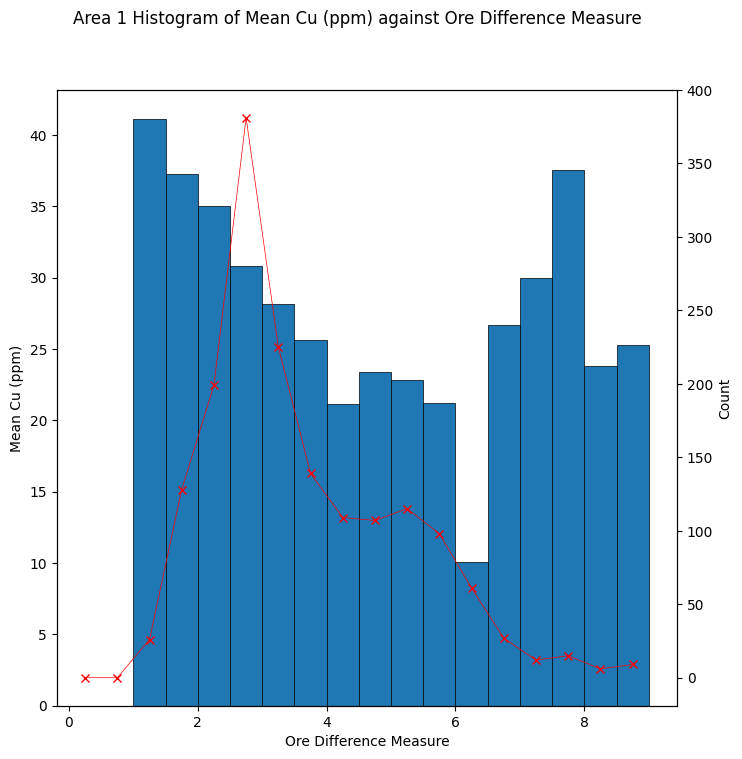

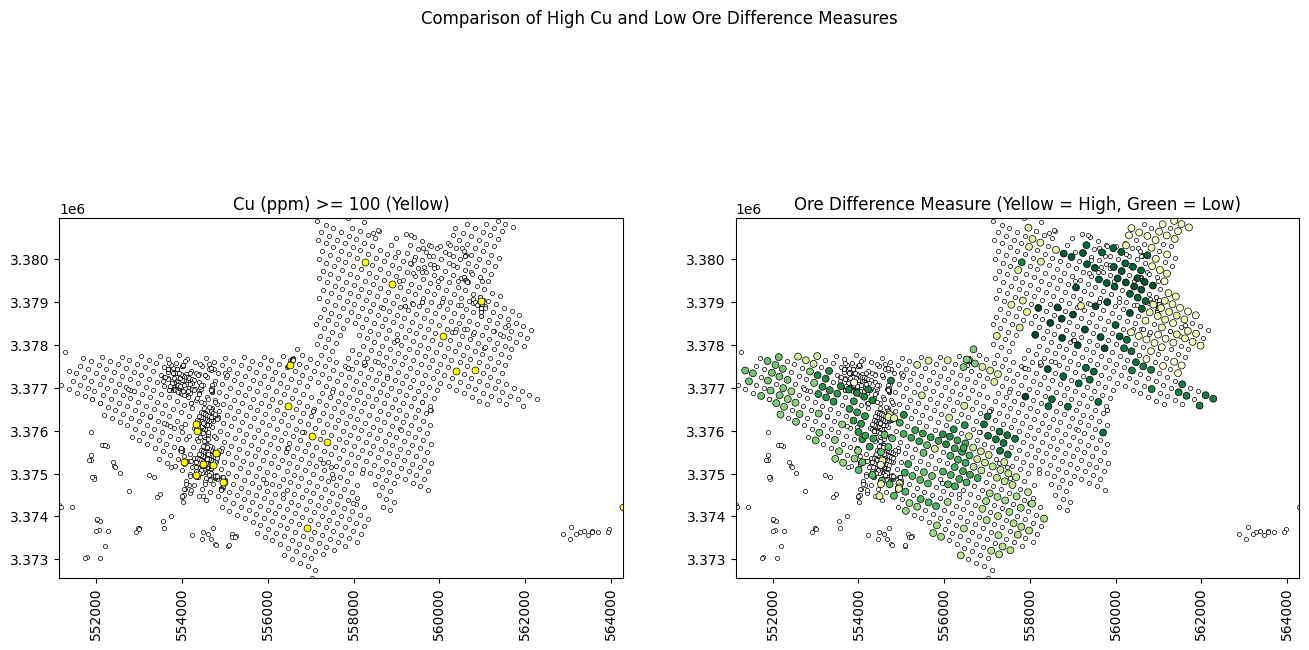

In [223]:
KEY_ELEMENT_COLUMNS: list[str] = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Mg (%)', 'CCPI', 'Ishikawa', 'As (ppm)']
AREA_1_ORE_SAMPLE  = "EX140145"



AREA_1_ORE_VECTOR: numpy.array = numpy.array([4, 4, 1, 2, 6, 1, 0.6, 0.5, 1])
NORMALIZATION_VECTOR: numpy.array = numpy.array([1.65, 11, 0.55, 0.55, 2.2, 0.55, 0.44, 0.33, 0.55])
AREA_1_ORE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_ORE_VECTOR, NORMALIZATION_VECTOR)

NORMALIZED_VECTOR_COLUMN: str = "NormalizedVector"
ORE_DIFFERENCE_COLUMN: str = "OreDifference"


area_1_data_frame[NORMALIZED_VECTOR_COLUMN] = area_1_data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: numpy.divide(x.to_numpy(), NORMALIZATION_VECTOR), axis = 1)
area_1_data_frame[ORE_DIFFERENCE_COLUMN] = area_1_data_frame[NORMALIZED_VECTOR_COLUMN].apply(lambda x: numpy.linalg.norm(x - AREA_1_ORE_NORMALIZED_VECTOR))



interval_size = 0.5
bar_labels: list[str] = []
bar_x_positions = []
bar_heights = []
bar_widths = []
bar_counts = []
for interval_start in numpy.arange(0, 9, interval_size):
    interval_end = interval_start + interval_size
    subset = area_1_data_frame[area_1_data_frame[ORE_DIFFERENCE_COLUMN].ge(interval_start) & area_1_data_frame[ORE_DIFFERENCE_COLUMN].lt(interval_end)]
    bar_labels.append(f"{interval_start:1f}")
    bar_x_positions.append(interval_start + (interval_size / 2))
    bar_heights.append(subset[COPPER_COLUMN].mean())
    bar_counts.append(subset[COPPER_COLUMN].count())
    bar_widths.append(interval_size)
    print(f"{interval_start:2f} to {interval_end:2f}: {subset[COPPER_COLUMN].mean()} ({subset[COPPER_COLUMN].count()})")


figure, axes = matplotlib.pyplot.subplots(figsize = (8, 8))
figure.suptitle("Area 1 Histogram of Mean Cu (ppm) against Ore Difference Measure")
ax2 = axes.twinx()
axes.bar(bar_x_positions, bar_heights, width = bar_widths, label = bar_labels, linewidth = 0.5, edgecolor = "black")
ax2.plot(bar_x_positions, bar_counts, color = "red", linewidth = 0.5, label = "Count", marker = "x")
axes.set_xlabel("Ore Difference Measure")
axes.set_ylabel("Mean Cu (ppm)")
ax2.set_ylabel("Count")


ORE_DIFF_THRESHOLD: float = 2.5
COPPER_THRESHOLD: float = 100

figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize = (16, 8))
figure.suptitle("Comparison of High Cu and Low Ore Difference Measures")

x_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min()
x_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max()
y_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).min()
y_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).max()

for i in range(0, 2):
    axes[i].set_xlim(xmin = x_min, xmax = x_max)
    axes[i].set_ylim(ymin = y_min, ymax = y_max)

area_1_data_frame.plot(ax = axes[0], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_1_data_frame[area_1_data_frame[COPPER_COLUMN].ge(COPPER_THRESHOLD)].plot(ax=axes[0], legend = True, color="yellow", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[0].set_title(f"Cu (ppm) >= {COPPER_THRESHOLD} (Yellow)")
# axes.xticks(rotation=45)
axes[0].tick_params(axis='x', labelrotation=90)


area_1_data_frame.plot(ax = axes[1], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_1_data_frame[area_1_data_frame[ORE_DIFFERENCE_COLUMN].le(ORE_DIFF_THRESHOLD)].plot(ax=axes[1], legend = True, cmap = "YlGn_r", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[1].set_title("Ore Difference Measure (Yellow = High, Green = Low)")
axes[1].tick_params(axis='x', labelrotation=90)


In [224]:
area_1_data_frame["Actual"] = area_1_data_frame[COPPER_COLUMN].apply(lambda x: x>=COPPER_THRESHOLD)
area_1_data_frame["Predicted"] = area_1_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=ORE_DIFF_THRESHOLD)

tp: int = len(area_1_data_frame[area_1_data_frame["Actual"] & area_1_data_frame["Predicted"]])
fp: int = len(area_1_data_frame[~area_1_data_frame["Actual"] & area_1_data_frame["Predicted"]])
fn: int = len(area_1_data_frame[area_1_data_frame["Actual"] & ~area_1_data_frame["Predicted"]])
tn: int = len(area_1_data_frame[~area_1_data_frame["Actual"] & ~area_1_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score, 4)}")
area_1_data_frame['classification'] = ''

area_1_data_frame.loc[area_1_data_frame['Actual'] & area_1_data_frame['Predicted'], 'classification'] = 'TP'
area_1_data_frame.loc[area_1_data_frame['Actual'] & ~area_1_data_frame['Predicted'], 'classification'] = 'FN'
area_1_data_frame.loc[~area_1_data_frame['Actual'] & area_1_data_frame['Predicted'], 'classification'] = 'FP'
area_1_data_frame.loc[~area_1_data_frame['Actual'] & ~area_1_data_frame['Predicted'], 'classification'] = 'TN'

True Positives = 6 | False Positives = 347 | False Negatives = 15 | True Negatives = 1355
Accuracy = 0.7899 | Precision = 0.017 | Recall = 0.2857 | F1 Score = 0.0321


In [225]:
area_1_data_frame.to_excel('best_100_Area2.xlsx', index=False)